# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [1]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
sns.set_style('darkgrid')
%run functions.py


## Exploring the simple model where volatility has 3 options

In [2]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps=252, return_sigma = False):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    if return_sigma:
        return (paths, sigma)
    else:
        return paths
    
    

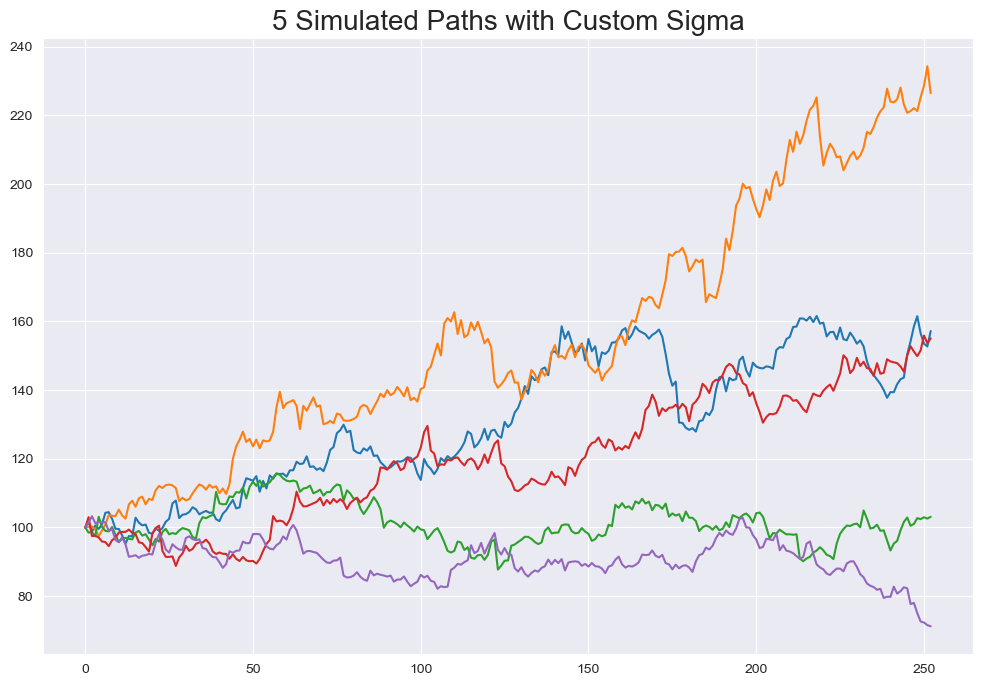

In [3]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252


simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

### Standard hedging
First, let's see what happens to the standard hedging.

We can see that it has a very big standard deviation, but still converges to the Black-Sholes value.

Black-Scholes value of call option: $5.13
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 1 delta hedges: $45.50
Standard deviation: $23.51
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 50 delta hedges: $6.44
Standard deviation: $3.46
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 100 delta hedges: $5.80
Standard deviation: $2.42
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 200 delta hedges: $5.

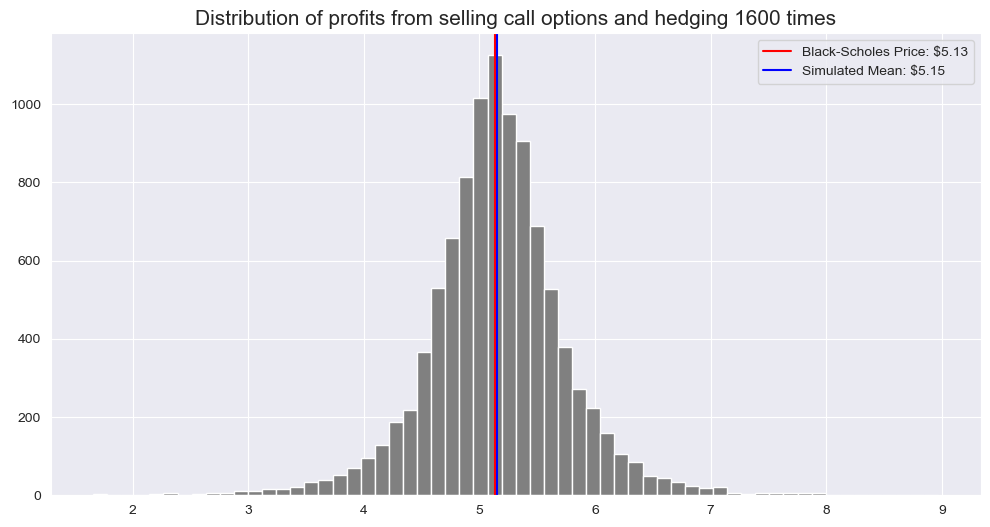

In [4]:
def bs_MC_call_sell(S0, K, sigma, t, r, n_sim, n_hedges=1, P=0, num_options=1, mu = 0):
    """
    Monte Carlo simulation for profit distribution of delta hedging at regular intervals a sold call option.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility (annualized)
        t (float): Time to expiration in years
        r (float): Risk-free interest rate
        n_sim (int): Number of Monte Carlo simulation paths
        n_hedges (int): Number of hedge rebalancing intervals
        P (float): Premium received per option sold
        num_options (int): Number of options sold
        mu (float): Drift of stock movement

    Returns:
        np.ndarray: Profit and loss of the dynamically hedged portfolio under each simulation at regular intervals
    """
    dt = t / n_hedges
    times = np.linspace(t - dt, 0, n_hedges)  # Time remaining at each hedge step

    # Simulate asset paths
    S_paths = stock_path_custom_sigma(S0, t, r, mu, n_sim, n_hedges)
    
    # Adjoin S0 to beginning of each stock path
    S_paths = np.hstack([S0 * np.ones((n_sim, 1)), S_paths])  # Shape: (n_sim, n_hedges + 1)

    # Compute discounted stock profits from each hedge interval
    # We are still cheating in the simulation as we use the black-scholes formula for delta
    discounted_stock_profits = []
    for i in range(n_hedges):
        S_start = S_paths[:, i]
        S_end = S_paths[:, i + 1]
        tte = t - i * dt
        delta = bs_call_delta(S_start, K, sigma, tte, r)
        stock_profit = np.exp(-r * ((i+1) * dt)) * (S_end - np.exp(r * dt) * S_start) * delta
        discounted_stock_profits.append(stock_profit)

    # Convert list of arrays to shape (n_hedges, n_sim), then sum over hedge steps
    total_stock_profit = np.sum(discounted_stock_profits, axis=0)  # shape (n_sim,)

    # Call payouts at final time
    S_end = S_paths[:, -1]
    call_payouts = np.exp(-r * t) * np.maximum(S_end - K, 0)

    # Final P&L
    pnl = num_options * (P - call_payouts + total_stock_profit)

    return pnl

##Demonstration that Delta hedging removes drift from Black-Scholes Price

S0 = 35
K = 34
sigma = .3
t = 1
r = 0.03
premium = 0
options_sold = 1
n_sim = 10000
mu = .8

bs_price = bs_call(S0,K,sigma,t,r)
print(f'Black-Scholes value of call option: ${bs_price:.2f}')

print('----'*20)
print('----'*20)



n_delta_hedges = [1, 50, 100, 200, 400, 800, 1600]

for n in n_delta_hedges:
    X = -bs_MC_call_sell(S0, K, sigma, t, r, n_sim, n_hedges=n, P=0, num_options=1, mu = mu)
    
    print(f'Black Scholes simulated value with {n} delta hedges: ${np.mean(X):.2f}')
    print(f'Standard deviation: ${np.std(X):.2f}')
    print('----'*20)
    print('----'*20)
    

plt.figure(figsize = (12,6))
plt.hist(X,bins = 60, color = 'grey')
plt.title('Distribution of profits from selling call options and hedging 1600 times', size = 15)
plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')
plt.axvline(np.mean(X), label = f'Simulated Mean: ${np.mean(X):.2f}', color = 'blue')
    
plt.legend()
plt.show()


### Now, let's try to compute delta using volatility at each step.
We get faster convergence, than previously, although, the standard deviation is still significant.

Black-Scholes value of call option: $5.13
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 1 delta hedges: $17.47
Standard deviation: $8.70
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 10 delta hedges: $5.55
Standard deviation: $1.11
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 20 delta hedges: $5.22
Standard deviation: $0.84
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 30 delta hedges: $5.09


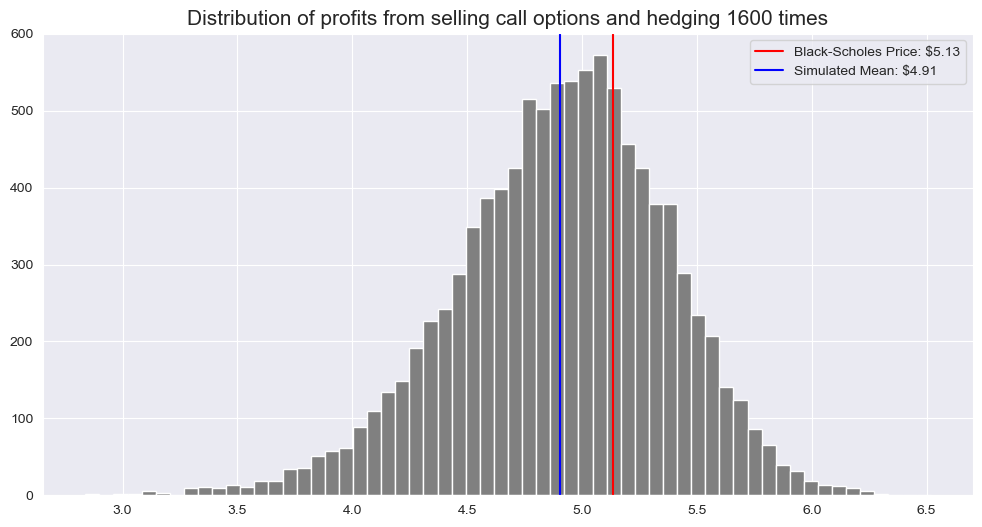

In [5]:
def stock_path_custom_sigma_with_volatility(S0, t, r, mu, n_paths, n_steps=252):
    '''
    Modified version that returns both stock paths AND volatility paths
    for vega hedging simulation.
    
    Each step of the log-returns, there is a 
    1) 50% chance the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Returns:
    - paths: Stock price paths
    - volatility_paths: Volatility used at each step
    '''
    
    # Noise in volatility
    noise = np.random.normal(0, 1, size=(n_paths, n_steps))
    
    # Custom sigma that is not constant
    sigma = np.random.choice([.2, .3, .45], p=[.5, .3, .2], size=(n_paths, n_steps))
    
    # Time increment between each step
    dt = t / n_steps
    
    # Log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    # Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis=1)
    
    # Paths
    paths = S0 * np.exp(log_returns)
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    return paths, sigma



def bs_MC_call_sell_know_sigma(S0, K, t, r, n_sim, n_hedges=1, P=0, num_options=1, mu = 0):
    """
    Monte Carlo simulation for profit distribution of delta hedging at regular intervals a sold call option.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility (annualized)
        t (float): Time to expiration in years
        r (float): Risk-free interest rate
        n_sim (int): Number of Monte Carlo simulation paths
        n_hedges (int): Number of hedge rebalancing intervals
        P (float): Premium received per option sold
        num_options (int): Number of options sold
        mu (float): Drift of stock movement

    Returns:
        np.ndarray: Profit and loss of the dynamically hedged portfolio under each simulation at regular intervals
        
        
    Additional Information:
    Default values of mu = 0, P = 0, and num_options = 1 returns the 
    negative simulated Black-Scholes value of a call option
    with n_hedges number of control variates in simulation.
    """
    dt = t / n_hedges
    times = np.linspace(t - dt, 0, n_hedges)  # Time remaining at each hedge step

    # Simulate asset paths
    S_paths, sigma = stock_path_custom_sigma(S0, t, r, mu, n_sim, n_hedges, return_sigma = True)
    #S_paths = stock_path_custom_sigma(S0, t, r, mu, n_sim, n_hedges)    
    #sigma = np.hstack([0.3 * np.ones((n_sim, 1)), sigma])
    
    # Compute discounted stock profits from each hedge interval
    # We are still cheating in the simulation as we use the black-scholes formula for delta
    discounted_stock_profits = []
    for i in range(n_hedges):
        S_start = S_paths[:, i]
        S_end = S_paths[:, i + 1]
        tte = t - i * dt

        delta = bs_call_delta(S_start, K, sigma[:,i], tte, r)
        stock_profit = np.exp(-r * ((i+1) * dt)) * (S_end - np.exp(r * dt) * S_start) * delta
        discounted_stock_profits.append(stock_profit)

    # Convert list of arrays to shape (n_hedges, n_sim), then sum over hedge steps
    total_stock_profit = np.sum(discounted_stock_profits, axis=0)  # shape (n_sim,)

    # Call payouts at final time
    S_end = S_paths[:, -1]
    call_payouts = np.exp(-r * t) * np.maximum(S_end - K, 0)

    # Final P&L
    pnl = num_options * (P - call_payouts + total_stock_profit)

    return pnl



S0 = 35
K = 34
sigma = .3
t = 1
r = 0.03
premium = 0
options_sold = 1
n_sim = 10000
mu = .8
window = 20
n_steps = 1000

bs_price = bs_call(S0,K,sigma,t,r)
print(f'Black-Scholes value of call option: ${bs_price:.2f}')

print('----'*20)
print('----'*20)



n_delta_hedges = [1,10,20,30, 50, 100, 200, 400, 800, 1600]

for n in n_delta_hedges:
    X = -bs_MC_call_sell_know_sigma(S0, K, t, r, n_sim, n_hedges=n, P=0, num_options=1, mu = mu)
    
    print(f'Black Scholes simulated value with {n} delta hedges: ${np.mean(X):.2f}')
    print(f'Standard deviation: ${np.std(X):.2f}')
    print('----'*20)
    print('----'*20)
    
    
plt.figure(figsize = (12,6))
plt.hist(X,bins = 60, color = 'grey')
plt.title('Distribution of profits from selling call options and hedging 1600 times', size = 15)
plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')
plt.axvline(np.mean(X), label = f'Simulated Mean: ${np.mean(X):.2f}', color = 'blue')
    
plt.legend()
plt.show()

### Let's try using mean volatility as sigma for computing delta.
This gives us much faster convergence than previously. 

Black-Scholes value of call option: $5.13
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 1 delta hedges: $16.32
Standard deviation: $7.85
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 10 delta hedges: $5.49
Standard deviation: $0.92
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 20 delta hedges: $5.22
Standard deviation: $0.62
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 30 delta hedges: $5.12


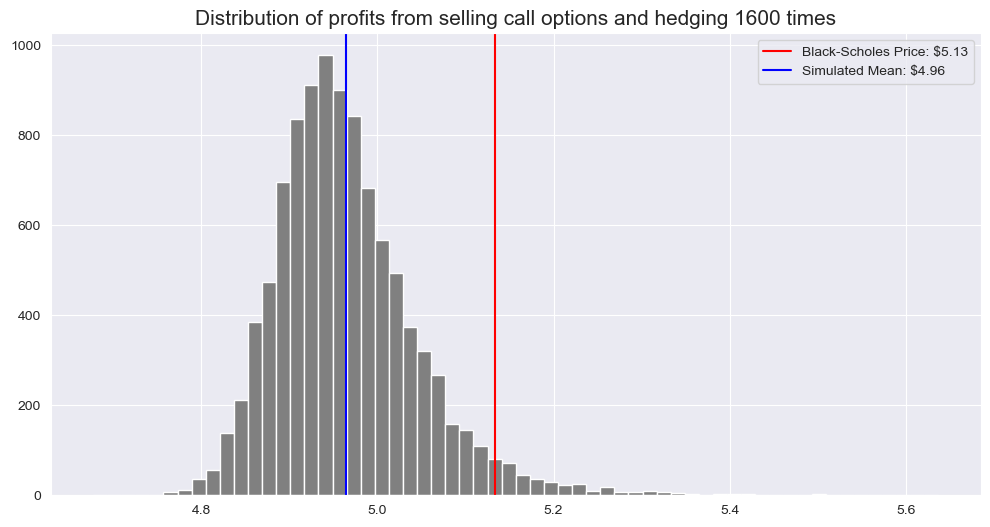

In [6]:
def bs_MC_call_sell_mean_sigma(S0, K, window, t, r, n_sim, n_hedges=1, P=0, num_options=1, mu = 0):
    """
    Monte Carlo simulation for profit distribution of delta hedging at regular intervals a sold call option.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility (annualized)
        t (float): Time to expiration in years
        r (float): Risk-free interest rate
        n_sim (int): Number of Monte Carlo simulation paths
        n_hedges (int): Number of hedge rebalancing intervals
        P (float): Premium received per option sold
        num_options (int): Number of options sold
        mu (float): Drift of stock movement

    Returns:
        np.ndarray: Profit and loss of the dynamically hedged portfolio under each simulation at regular intervals
        
        
    Additional Information:
    Default values of mu = 0, P = 0, and num_options = 1 returns the 
    negative simulated Black-Scholes value of a call option
    with n_hedges number of control variates in simulation.
    
    
    1. Collect last N stock prices: [S₀, S₁, S₂, ..., Sₙ]
2. Calculate returns: rᵢ = ln(Sᵢ/Sᵢ₋₁) 
3. Calculate standard deviation of returns: σ_daily = std(returns)
4. Annualize: σ_annual = σ_daily × √(252)  [for daily data]
    """
    dt = t / n_hedges
    times = np.linspace(t - dt, 0, n_hedges)  # Time remaining at each hedge step

    # Simulate asset paths and volatilities
    S_paths, vols = stock_path_custom_sigma(S0, t, r, mu, n_sim, n_hedges, return_sigma = True)
    sigma = vols.mean(axis = 1)

    # Compute discounted stock profits from each hedge interval
    discounted_stock_profits = []
    for i in range(n_hedges):
        S_start = S_paths[:, i]
        S_end = S_paths[:, i + 1]
        tte = t - i * dt            
        delta = bs_call_delta(S_start, K, sigma, tte, r)
        stock_profit = np.exp(-r * (i * dt)) * (S_end - np.exp(r * dt) * S_start) * delta
        discounted_stock_profits.append(stock_profit)

    # Convert list of arrays to shape (n_hedges, n_sim), then sum over hedge steps
    total_stock_profit = np.sum(discounted_stock_profits, axis=0)  # shape (n_sim,)

    # Call payouts at final time
    S_end = S_paths[:, -1]
    call_payouts = np.exp(-r * t) * np.maximum(S_end - K, 0)

    # Final P&L
    pnl = num_options * (P - call_payouts + total_stock_profit)

    return pnl

S0 = 35
K = 34
sigma = .3
t = 1
r = 0.03
premium = 0
options_sold = 1
n_sim = 10000
mu = .8
window = 20
n_steps = 1000

bs_price = bs_call(S0,K,sigma,t,r)
print(f'Black-Scholes value of call option: ${bs_price:.2f}')

print('----'*20)
print('----'*20)



n_delta_hedges = [1,10,20,30, 50, 100, 200, 400, 800, 1600]

for n in n_delta_hedges:
    X = -bs_MC_call_sell_mean_sigma(S0, K, window, t, r, n_sim, n_hedges=n, P=0, num_options=1, mu = mu)
    
    print(f'Black Scholes simulated value with {n} delta hedges: ${np.mean(X):.2f}')
    print(f'Standard deviation: ${np.std(X):.2f}')
    print('----'*20)
    print('----'*20)
    
plt.figure(figsize = (12,6))
plt.hist(X,bins = 60, color = 'grey')
plt.title(f"Distribution of profits from selling call options and hedging {n_delta_hedges[-1]} times", size = 15)
plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')
plt.axvline(np.mean(X), label = f'Simulated Mean: ${np.mean(X):.2f}', color = 'blue')
    
plt.legend()
plt.show()

### Computing volatility dynamically
Let's try to compute sigma at each step and compute delta using this value.
This method gives slower convergence than computing mean volatility.

Black-Scholes value of call option: $5.13
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 1 delta hedges: $16.48
Standard deviation: $7.85
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 10 delta hedges: $5.26
Standard deviation: $1.12
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 20 delta hedges: $4.96
Standard deviation: $1.01
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 30 delta hedges: $4.92


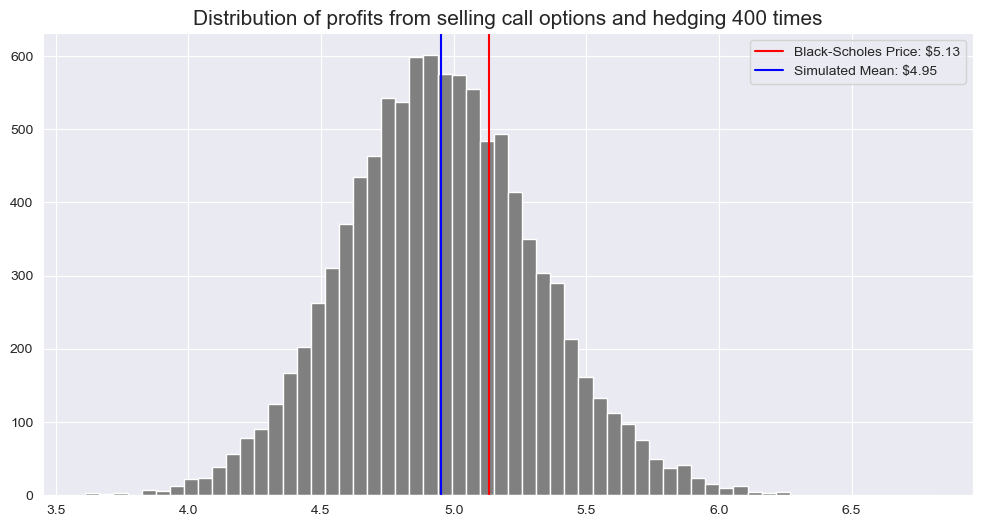

In [7]:
def bs_MC_call_sell_dyn_sigma(S0, K, window, t, r, n_sim, n_hedges=1, P=0, num_options=1, mu = 0):
    """
    Monte Carlo simulation for profit distribution of delta hedging at regular intervals a sold call option.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility (annualized)
        t (float): Time to expiration in years
        r (float): Risk-free interest rate
        n_sim (int): Number of Monte Carlo simulation paths
        n_hedges (int): Number of hedge rebalancing intervals
        P (float): Premium received per option sold
        num_options (int): Number of options sold
        mu (float): Drift of stock movement

    Returns:
        np.ndarray: Profit and loss of the dynamically hedged portfolio under each simulation at regular intervals
    """
    dt = t / n_hedges
    times = np.linspace(t - dt, 0, n_hedges)  # Time remaining at each hedge step

    # Simulate asset paths
    S_paths = stock_path_custom_sigma(S0, t, r, mu, n_sim, n_hedges)
    

    # Compute discounted stock profits from each hedge interval
    # We are still cheating in the simulation as we use the black-scholes formula for delta
    discounted_stock_profits = []
    for i in range(n_hedges):
        S_start = S_paths[:, i]
        S_end = S_paths[:, i + 1]
        tte = t - i * dt
        #Get recent prices
        recent_prices = S_paths[:, max(0, i-window):i+1]
        #Calculate returns
        returns = np.log(recent_prices[:, 1:] / recent_prices[:, :-1])

        #Estimate volatility
        if recent_prices.shape[1] >= 5: 
            returns = np.log(recent_prices[:, 1:] / recent_prices[:, :-1])
            sigma_estimates = np.std(returns, axis = 1) * np.sqrt(n_hedges) 
        else:
            sigma_estimates = np.full(n_sim, 0.25) #default sigma
            
        
        delta = bs_call_delta(S_start, K, sigma_estimates, tte, r)
        stock_profit = np.exp(-r * (i * dt)) * (S_end - np.exp(r * dt) * S_start) * delta
        discounted_stock_profits.append(stock_profit)

    # Convert list of arrays to shape (n_hedges, n_sim), then sum over hedge steps
    total_stock_profit = np.sum(discounted_stock_profits, axis=0)  # shape (n_sim,)

    # Call payouts at final time
    S_end = S_paths[:, -1]
    call_payouts = np.exp(-r * t) * np.maximum(S_end - K, 0)

    # Final P&L
    pnl = num_options * (P - call_payouts + total_stock_profit)

    return pnl

S0 = 35
K = 34
sigma = .3
t = 1
r = 0.03
premium = 0
options_sold = 1
n_sim = 10000
mu = .8
window = 20
n_steps = 1000

bs_price = bs_call(S0,K,sigma,t,r)
print(f'Black-Scholes value of call option: ${bs_price:.2f}')

print('----'*20)
print('----'*20)



n_delta_hedges = [1,10,20,30, 50, 100, 200, 400]

for n in n_delta_hedges:
    X = -bs_MC_call_sell_dyn_sigma(S0, K, window, t, r, n_sim, n_hedges=n, P=0, num_options=1, mu = mu)
    
    print(f'Black Scholes simulated value with {n} delta hedges: ${np.mean(X):.2f}')
    print(f'Standard deviation: ${np.std(X):.2f}')
    print('----'*20)
    print('----'*20)
    
plt.figure(figsize = (12,6))
plt.hist(X,bins = 60, color = 'grey')
plt.title('Distribution of profits from selling call options and hedging 400 times', size = 15)
plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')
plt.axvline(np.mean(X), label = f'Simulated Mean: ${np.mean(X):.2f}', color = 'blue')
    
plt.legend()
plt.show()

### Computing mean volatility dynamically
It still has slower convergance than using true mean volatility, but faster than other methods.

Black-Scholes value of call option: $5.13
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 1 delta hedges: $16.56
Standard deviation: $7.96
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 10 delta hedges: $5.27
Standard deviation: $1.13
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 20 delta hedges: $4.99
Standard deviation: $1.03
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 30 delta hedges: $4.91


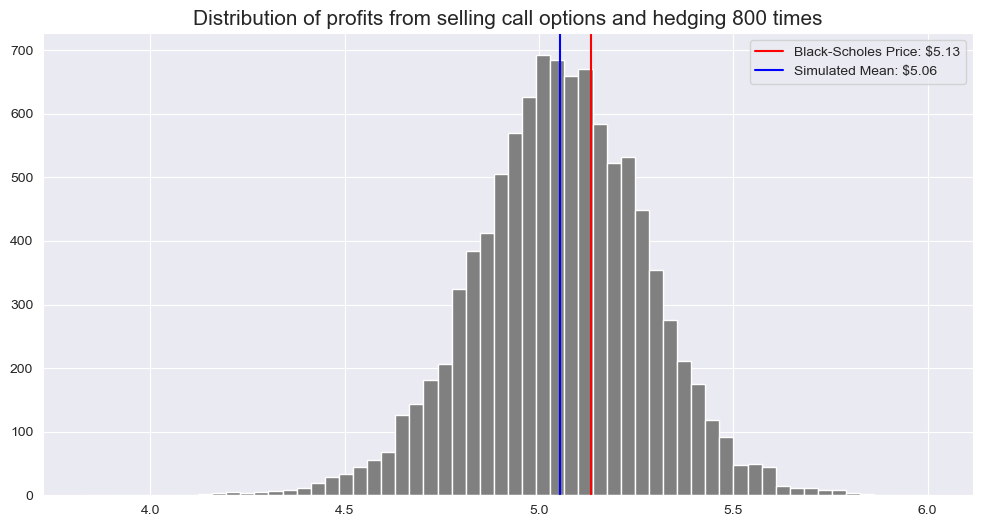

In [8]:
def bs_MC_call_sell_dyn_sigma(S0, K, window, t, r, n_sim, n_hedges=1, P=0, num_options=1, mu = 0):
    """
    Monte Carlo simulation for profit distribution of delta hedging at regular intervals a sold call option.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        sigma (float): Volatility (annualized)
        t (float): Time to expiration in years
        r (float): Risk-free interest rate
        n_sim (int): Number of Monte Carlo simulation paths
        n_hedges (int): Number of hedge rebalancing intervals
        P (float): Premium received per option sold
        num_options (int): Number of options sold
        mu (float): Drift of stock movement

    Returns:
        np.ndarray: Profit and loss of the dynamically hedged portfolio under each simulation at regular intervals
    """
    dt = t / n_hedges
    times = np.linspace(t - dt, 0, n_hedges)  # Time remaining at each hedge step

    # Simulate asset paths
    S_paths = stock_path_custom_sigma(S0, t, r, mu, n_sim, n_hedges)
    

    # Compute discounted stock profits from each hedge interval
    # We are still cheating in the simulation as we use the black-scholes formula for delta
    discounted_stock_profits = []
    for i in range(n_hedges):
        S_start = S_paths[:, i]
        S_end = S_paths[:, i + 1]
        tte = t - i * dt
        #Get recent prices
        recent_prices = S_paths[:, 0:i+1]
        #Calculate returns
        returns = np.log(recent_prices[:, 1:] / recent_prices[:, :-1])

        #Estimate volatility
        if recent_prices.shape[1] >= 5:  # Need at least 2 prices
            returns = np.log(recent_prices[:, 1:] / recent_prices[:, :-1])
            sigma_estimates = np.std(returns, axis = 1) * np.sqrt(n_hedges) 
        else:
            sigma_estimates = np.full(n_sim, 0.25) #default sigma
            
        delta = bs_call_delta(S_start, K, sigma_estimates, tte, r)
        stock_profit = np.exp(-r * (i * dt)) * (S_end - np.exp(r * dt) * S_start) * delta
        discounted_stock_profits.append(stock_profit)
        

    # Convert list of arrays to shape (n_hedges, n_sim), then sum over hedge steps
    total_stock_profit = np.sum(discounted_stock_profits, axis=0)  # shape (n_sim,)

    # Call payouts at final time
    S_end = S_paths[:, -1]
    call_payouts = np.exp(-r * t) * np.maximum(S_end - K, 0)

    # Final P&L
    pnl = num_options * (P - call_payouts + total_stock_profit)

    return pnl

S0 = 35
K = 34
sigma = .3
t = 1
r = 0.03
premium = 0
options_sold = 1
n_sim = 10000
mu = .8
window = 20
n_steps = 1000

bs_price = bs_call(S0,K,sigma,t,r)
print(f'Black-Scholes value of call option: ${bs_price:.2f}')

print('----'*20)
print('----'*20)



n_delta_hedges = [1,10,20,30, 50, 100, 200, 400, 800]

for n in n_delta_hedges:
    X = -bs_MC_call_sell_dyn_sigma(S0, K, window, t, r, n_sim, n_hedges=n, P=0, num_options=1, mu = mu)
    
    print(f'Black Scholes simulated value with {n} delta hedges: ${np.mean(X):.2f}')
    print(f'Standard deviation: ${np.std(X):.2f}')
    print('----'*20)
    print('----'*20)
    
plt.figure(figsize = (12,6))
plt.hist(X,bins = 60, color = 'grey')
plt.title(f"Distribution of profits from selling call options and hedging {n_delta_hedges[-1]} times", size = 15)
plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.2f}', color = 'red')
plt.axvline(np.mean(X), label = f'Simulated Mean: ${np.mean(X):.2f}', color = 'blue')
    
plt.legend()
plt.show()

#### We can see that delta-hedging of the given model converges to the Black-sholes model with volatility that equals to mean of volatilities.

### Vega Hedging
Let's try to make vega equal to zero. Since heuristically $C_0(\sigma(t_1)) - C_0(\sigma(t_2)) \approx vega \cdot (\sigma(t_1) - \sigma(t_2))$ having vega equal to zero should negate change in sigma.

For this we consider two options with different strike prices and hedgge them simultaneusly. We compute vega at the start and compute them in such ratio so that total vega is $0$.

Black-Scholes value of call option: $0.578
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 1 delta hedges: $-0.253
Standard deviation: $0.685
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 10 delta hedges: $0.522
Standard deviation: $0.089
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 20 delta hedges: $0.552
Standard deviation: $0.058
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Black Scholes simulated value with 30 delta hedges:

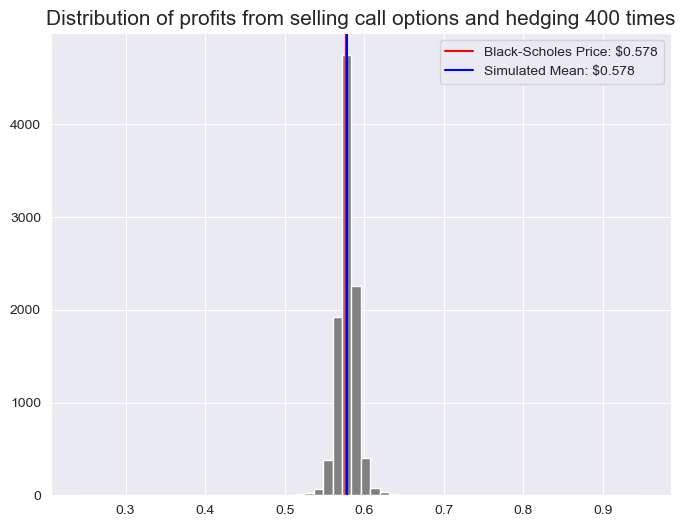

In [9]:
def bs_MC_call_sell_vega(S0, K1, K2, x1, x2, sigma, t, r, n_sim, n_hedges=1, P=0, num_options=1, mu = 0):
    """
    Monte Carlo simulation for profit distribution of delta hedging at regular intervals a sold call option.

    Parameters:
        S0 (float): Initial stock price
        K1 (float): Strike price of the first option
        K2 (float): Strike price of the second option
        sigma (float): Volatility (annualized)
        t (float): Time to expiration in years
        r (float): Risk-free interest rate
        n_sim (int): Number of Monte Carlo simulation paths
        n_hedges (int): Number of hedge rebalancing intervals
        P (float): Premium received per option sold
        num_options (int): Number of options sold
        mu (float): Drift of stock movement

    Returns:
        np.ndarray: Profit and loss of the dynamically hedged portfolio under each simulation at regular intervals

    """
    dt = t / n_hedges
    times = np.linspace(t - dt, 0, n_hedges)  # Time remaining at each hedge step

    # Simulate asset paths
    S_paths = stock_path_custom_sigma(S0, t, r, mu, n_sim, n_hedges)


    # Compute discounted stock profits from each hedge interval
    # We are still cheating in the simulation as we use the black-scholes formula for delta
    discounted_stock_profits = []
    for i in range(n_hedges):
        S_start = S_paths[:, i]
        S_end = S_paths[:, i + 1]
        tte = t - i * dt
        
        delta1 = bs_call_delta(S_start, K1, sigma, tte, r)
        delta2 = bs_call_delta(S_start, K2, sigma, tte, r)
        stock_profit = np.exp(-r * (i * dt)) * (S_end - np.exp(r * dt) * S_start) * (x1*delta1 + x2*delta2)
        discounted_stock_profits.append(stock_profit)

    # Convert list of arrays to shape (n_hedges, n_sim), then sum over hedge steps
    total_stock_profit = np.sum(discounted_stock_profits, axis=0)  # shape (n_sim,)

    # Call payouts at final time
    S_end = S_paths[:, -1]
    call_payouts1 = np.exp(-r * t) * np.maximum(S_end - K1, 0)
    call_payouts2 = np.exp(-r * t) * np.maximum(S_end - K2, 0)

    # Final P&L
    pnl = num_options * (P - x1* call_payouts1 - x2*call_payouts2 + total_stock_profit)

    return pnl

S0 = 35
K1 = 34
K2 = 36
sigma = .3
t = 1
r = 0.03
premium = 0
options_sold = 1
n_sim = 10000
mu = .8

vega1 = bs_vega(S0, K1, sigma, t, r)
vega2 = bs_vega(S0, K2, sigma, t, r)

x = abs(vega1) + abs(vega2)
x1 = vega2 / x
x2 = -vega1 /x

bs_price = x1*bs_call(S0,K1,sigma,t,r)+x2*bs_call(S0,K2,sigma,t,r)
print(f'Black-Scholes value of call option: ${bs_price:.3f}')

print('----'*20)
print('----'*20)



n_delta_hedges = [1,10,20,30, 50, 100, 200, 400]

for n in n_delta_hedges:
    X = -bs_MC_call_sell_vega(S0, K1,K2, x1, x2, sigma, t, r, n_sim, n_hedges=n, P=0, num_options=1, mu = mu)
    
    print(f'Black Scholes simulated value with {n} delta hedges: ${np.mean(X):.3f}')
    print(f'Standard deviation: ${np.std(X):.3f}')
    print('----'*20)
    print('----'*20)
    
plt.figure(figsize = (8,6))
plt.hist(X,bins = 60, color = 'grey')
plt.title('Distribution of profits from selling call options and hedging 400 times', size = 15)
plt.axvline(bs_price, label = f'Black-Scholes Price: ${bs_price:.3f}', color = 'red')
plt.axvline(np.mean(X), label = f'Simulated Mean: ${np.mean(X):.3f}', color = 'blue')
    
plt.legend()
plt.show()

## Using Heston model from the lecture 12

In [10]:
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.integrate import quad


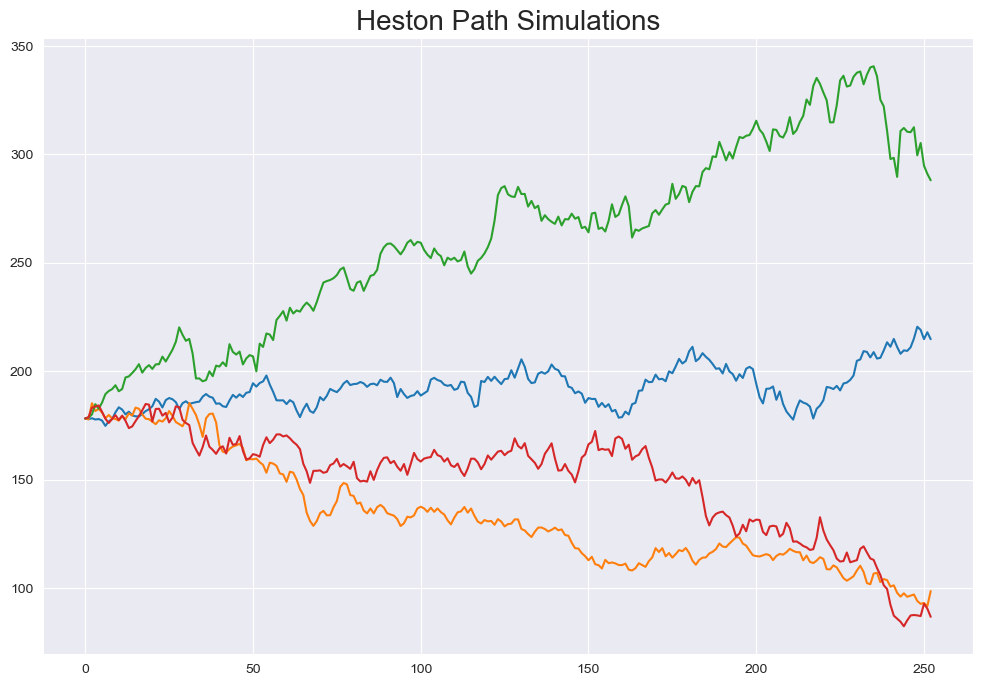

In [11]:
S0 = 35
K = 34

kappa = 2.4 #Mean reversion rate of variance of log-returns (Typical range 1 to 5)

theta = .3**2 #Long run variance of log-returns

xi = .43 # Volatility of Volatility (Typical range .2 to 1)

v0 = .22**2 #Initial variance of log-returns

rho = -.6 #Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)

S0 = 178.2 #Initial Stock Value

t = 1 #Time horizon

n_steps = 252 #Number of steps in each simulation

r = .039 #Risk-free interest rate

n_sims = 4 #Number of simulations

mu = .034 #Excess drift of log returns



heston_paths = heston_path_sim(S0, v0, r, t, n_steps, kappa, theta, xi, rho, n_sims, mu)

plt.figure(figsize = (12,8))
for path in heston_paths:
    plt.plot(path)
    
    
plt.title('Heston Path Simulations', size = 20)

plt.show()

Here we wrote a function to compute delta of the Heston model using Monte-Carlo method, but we didn't use it in our computations since it required too many simulations to get an accurate estimate, making it very slow when using inside anothe Monte-Carlo simulation.  

In [12]:
def Heston_MC_call_delta(S0, K, v0, r, t, kappa, theta, xi, rho, mu, n_steps = 100, delta_sims = int(25000)):
    """Description: 
    Monte-Carlo Simulation of Heston Call Delta
    """
    bump = .01*S0 #epsilon in above estimation
    
    # Commented out local path simulation - using heston_path_sim instead
    
    dt = t/n_steps
    def paths(S0):
        S = np.full((n_steps, delta_sims), S0)
        v = np.full((n_steps, delta_sims), v0)
        for i in range(1,n_steps):
            noise_v = np.random.normal(0,1,delta_sims)
            noise_s = rho*noise_v + np.sqrt(1 - rho**2)*np.random.normal(0,1,delta_sims)
        
            v[i] = abs(v[i-1] + kappa*(theta - v[i-1])*dt + xi*np.sqrt(abs(v[i-1])*dt)*noise_v)
    
            log_returns = (mu + r - 0.5*v[i])*dt + xi*np.sqrt(abs(v[i-1])*dt)*noise_s
            S[i] = S[i-1]*np.exp(log_returns)
        return S[-1]
    
    #paths_up = heston_path_sim(S0+bump, v0, r, t, n_steps, kappa, theta, xi, rho, delta_sims, mu = mu)
    paths_up = paths(S0+bump)
    #paths_down = heston_path_sim(S0-bump, v0, r, t, n_steps, kappa, theta, xi, rho, delta_sims, mu = mu)
    paths_down = paths(S0-bump)
    calls_up = np.maximum(paths_up - K, 0)*np.exp(-r*t)

    calls_down = np.maximum(paths_down - K, 0)*np.exp(-r*t)

    delta_sims = (calls_up - calls_down)/(2*bump)


    delta_estimate = np.mean(delta_sims)

    return delta_estimate

In [13]:
Heston_MC_call_delta(S0, K, v0, r, t, kappa, theta, xi, rho, mu)

1.0191140043444653

### Delta-hedging on Heston model

We tried using Black-Sholes delta to estimate the value of call options. Although the mean was very close to the heston value, the standard deviation was far too big.

##### First, we tried to compute delta using the actual values of volatilities.

Heston value of call option: $4.83
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Heston simulated value with 1 delta hedges: $6.41
Standard deviation: $6.32
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Heston simulated value with 50 delta hedges: $4.78
Standard deviation: $2.72
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Heston simulated value with 100 delta hedges: $4.75
Standard deviation: $2.52
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Heston simulated value with 200 delta hedges: $4.79
Standard deviation: $2.45
--------

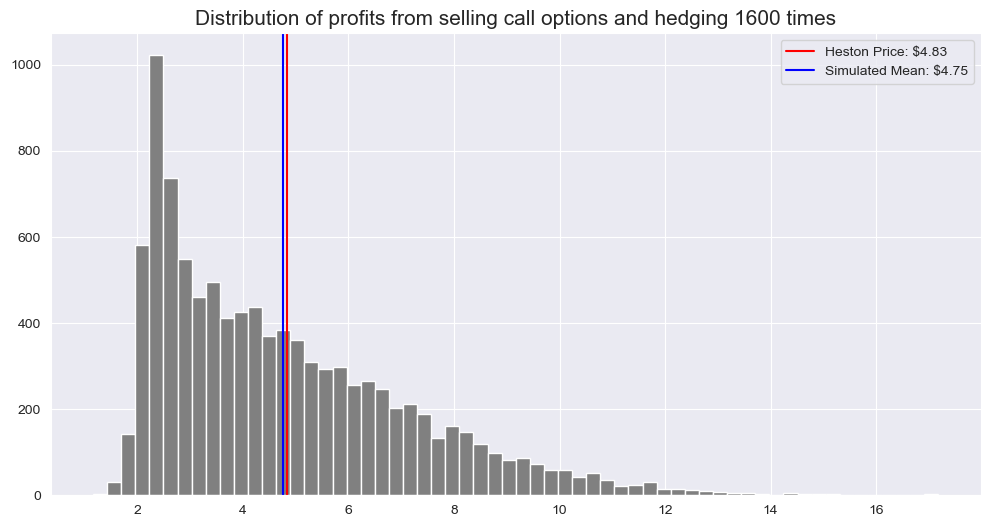

In [14]:
def Heston_MC_call_sell(S0, K, v0, r, t, kappa, theta, xi, rho, mu, n_sim, n_hedges=1, P=0, num_options=1):
    """
    Monte Carlo simulation for profit distribution of delta hedging at regular intervals a sold call option.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        kappa (float) : Mean reversion rate of variance of log-returns (Typical range 1 to 5)

        theta (float): Long run variance of log-returns

        xi (float): Volatility of Volatility (Typical range .2 to 1)
 
        v0 (float): Initial variance of log-returns

        rho (float): Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)

        S0 (float): Initial Stock Value

        t (float): Time horizon

        n_steps (int): Number of steps in each simulation

        r (float): Risk-free interest rate

        mu (float): Excess drift of log returns
        
        n_sim (int): Number of Monte Carlo simulation paths
        
        n_hedges (int): Number of hedge rebalancing intervals
        
        P (float): Premium received per option sold
        
        num_options (int): Number of options sold
        
        mu (float): Drift of stock movement

    Returns:
        np.ndarray: Profit and loss of the dynamically hedged portfolio under each simulation at regular intervals
    """
    dt = t / n_hedges
    times = np.linspace(t - dt, 0, n_hedges)  # Time remaining at each hedge step

    # Simulate asset paths
    S_paths, vols = heston_path_sim(S0, v0, r, t, n_hedges, kappa, theta, xi, rho, n_sim, mu = mu, return_vol = True)
    # Adjoin S0 to beginning of each stock path
    S_paths = np.hstack([S0 * np.ones((n_sim, 1)), S_paths])  # Shape: (n_sim, n_hedges + 1)
    # Compute discounted stock profits from each hedge interval
    discounted_stock_profits = []
    for i in range(n_hedges):
        S_start = S_paths[:, i]
        S_end = S_paths[:, i + 1]
        tte = t - i * dt
        delta = bs_call_delta(S_start, K, vols[:, i], r, tte) #using volatilities from the model
        stock_profit = np.exp(-r * ((i+1) * dt)) * (S_end - np.exp(r * dt) * S_start) * delta
        discounted_stock_profits.append(stock_profit)

    # Convert list of arrays to shape (n_hedges, n_sim), then sum over hedge steps
    total_stock_profit = np.sum(discounted_stock_profits, axis=0)  # shape (n_sim,)

    # Call payouts at final time
    S_end = S_paths[:, -1]
    call_payouts = np.exp(-r * t) * np.maximum(S_end - K, 0)

    # Final P&L
    pnl = num_options * (P - call_payouts + total_stock_profit)

    return pnl

S0 = 35
K = 34
kappa = 2 #Mean reversion rate of variance of log-returns (Typical range 1 to 5)

theta = .3**2 #Long run variance of log-returns

xi = .43 # Volatility of Volatility (Typical range .2 to 1)

v0 = .22**2 #Initial variance of log-returns

rho = -.6 #Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)


t = 1 #Time horizon

n_steps = 252 #Number of steps in each simulation

r = .039 #Risk-free interest rate

mu = .034 #Excess drift of log returns
premium = 0
options_sold = 1
n_sim = 10000


heston_price = heston_call(S0, K, v0, r, t, kappa, theta, xi, rho)
print(f'Heston value of call option: ${heston_price:.2f}')

print('----'*20)
print('----'*20)



n_delta_hedges = [1, 50, 100, 200, 400, 800, 1600]

for n in n_delta_hedges:
    X = -Heston_MC_call_sell(S0, K, v0, r, t, kappa, theta, xi, rho, mu, n_sim, n_hedges=n, P=0, num_options=1)
    
    print(f'Heston simulated value with {n} delta hedges: ${np.mean(X):.2f}')
    print(f'Standard deviation: ${np.std(X):.2f}')
    print('----'*20)
    print('----'*20)
    

plt.figure(figsize = (12,6))
plt.hist(X,bins = 60, color = 'grey')
plt.title(f'Distribution of profits from selling call options and hedging {n_delta_hedges[-1]} times', size = 15)
plt.axvline(heston_price, label = f'Heston Price: ${heston_price:.2f}', color = 'red')
plt.axvline(np.mean(X), label = f'Simulated Mean: ${np.mean(X):.2f}', color = 'blue')
    
plt.legend()
plt.show()

##### Secondly, we used mean value of actual volatilities to compute delta.

Heston value of call option: $4.83
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Heston simulated value with 1 delta hedges: $6.35
Standard deviation: $6.34
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Heston simulated value with 50 delta hedges: $4.83
Standard deviation: $2.74
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Heston simulated value with 100 delta hedges: $4.78
Standard deviation: $2.60
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Heston simulated value with 200 delta hedges: $4.72
Standard deviation: $2.46
--------

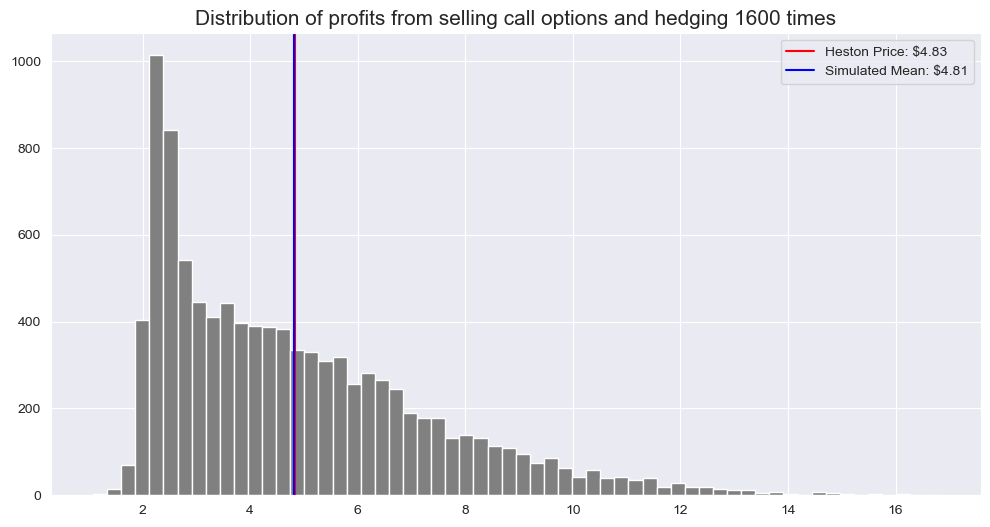

In [15]:
def Heston_MC_call_sell(S0, K, v0, r, t, kappa, theta, xi, rho, mu, n_sim, n_hedges=1, P=0, num_options=1):
    """
    Monte Carlo simulation for profit distribution of delta hedging at regular intervals a sold call option.

    Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        kappa (float) : Mean reversion rate of variance of log-returns (Typical range 1 to 5)

        theta (float): Long run variance of log-returns

        xi (float): Volatility of Volatility (Typical range .2 to 1)
 
        v0 (float): Initial variance of log-returns

        rho (float): Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)

        S0 (float): Initial Stock Value

        t (float): Time horizon

        n_steps (int): Number of steps in each simulation

        r (float): Risk-free interest rate

        mu (float): Excess drift of log returns
        
        n_sim (int): Number of Monte Carlo simulation paths
        
        n_hedges (int): Number of hedge rebalancing intervals
        
        P (float): Premium received per option sold
        
        num_options (int): Number of options sold
        
        mu (float): Drift of stock movement

    Returns:
        np.ndarray: Profit and loss of the dynamically hedged portfolio under each simulation at regular intervals
    """
    dt = t / n_hedges
    times = np.linspace(t - dt, 0, n_hedges)  # Time remaining at each hedge step

    # Simulate asset paths
    S_paths, vols = heston_path_sim(S0, v0, r, t, n_hedges, kappa, theta, xi, rho, n_sim, mu = mu, return_vol = True)
    # Adjoin S0 to beginning of each stock path
    S_paths = np.hstack([S0 * np.ones((n_sim, 1)), S_paths])  # Shape: (n_sim, n_hedges + 1)
    # Compute discounted stock profits from each hedge interval
    discounted_stock_profits = []
    for i in range(n_hedges):
        S_start = S_paths[:, i]
        S_end = S_paths[:, i + 1]
        tte = t - i * dt
        delta = bs_call_delta(S_start, K, np.mean(vols, axis = 1), r, tte) #using mean volatility from the model
        stock_profit = np.exp(-r * ((i+1) * dt)) * (S_end - np.exp(r * dt) * S_start) * delta
        discounted_stock_profits.append(stock_profit)

    # Convert list of arrays to shape (n_hedges, n_sim), then sum over hedge steps
    total_stock_profit = np.sum(discounted_stock_profits, axis=0)  # shape (n_sim,)

    # Call payouts at final time
    S_end = S_paths[:, -1]
    call_payouts = np.exp(-r * t) * np.maximum(S_end - K, 0)

    # Final P&L
    pnl = num_options * (P - call_payouts + total_stock_profit)

    return pnl

##Demonstration that Delta hedging removes drift from Black-Scholes Price

S0 = 35
K = 34
kappa = 2 #Mean reversion rate of variance of log-returns (Typical range 1 to 5)

theta = .3**2 #Long run variance of log-returns

xi = .43 # Volatility of Volatility (Typical range .2 to 1)

v0 = .22**2 #Initial variance of log-returns

rho = -.6 #Correlation of random noise of variance and log-returns (Typical range -.9 to -.4)


t = 1 #Time horizon

n_steps = 252 #Number of steps in each simulation

r = .039 #Risk-free interest rate

mu = .034 #Excess drift of log returns
premium = 0
options_sold = 1
n_sim = 10000


heston_price = heston_call(S0, K, v0, r, t, kappa, theta, xi, rho)
print(f'Heston value of call option: ${heston_price:.2f}')

print('----'*20)
print('----'*20)



n_delta_hedges = [1, 50, 100, 200, 400, 800, 1600]

for n in n_delta_hedges:
    X = -Heston_MC_call_sell(S0, K, v0, r, t, kappa, theta, xi, rho, mu, n_sim, n_hedges=n, P=0, num_options=1)
    
    print(f'Heston simulated value with {n} delta hedges: ${np.mean(X):.2f}')
    print(f'Standard deviation: ${np.std(X):.2f}')
    print('----'*20)
    print('----'*20)
    

plt.figure(figsize = (12,6))
plt.hist(X,bins = 60, color = 'grey')
plt.title(f'Distribution of profits from selling call options and hedging {n_delta_hedges[-1]} times', size = 15)
plt.axvline(heston_price, label = f'Heston Price: ${heston_price:.2f}', color = 'red')
plt.axvline(np.mean(X), label = f'Simulated Mean: ${np.mean(X):.2f}', color = 'blue')
    
plt.legend()
plt.show()

Both results had very big standard deviations, which means that we need some other method to estimate delta.